# Работа с YOLOv8. Детекция, сегментация, классификация, поиск ключевых точек

YOLO (You Only Look Once) — нейронная сеть, предназначенная работы с объектами на изображениях. Может решать следующие задачи:

* Детекция - обнаружение объектов

* Сегментация - разделение изображения на области, которые относятся к каждому объекту

* Классификация - определение того, что находится на изображении

* Поиск ключевых точек тела - для определения позы человека

* Трекинг объектов - потоковая обработка, при которой для каждого объекта возможно сохранять и использовать историю местоположения

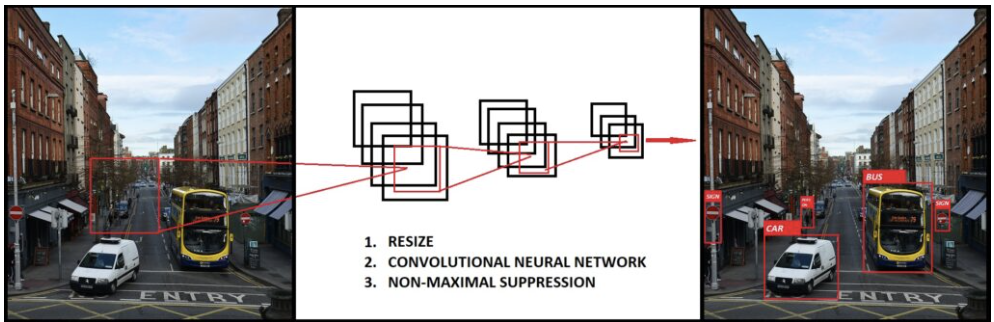

## Принцип работы YOLO

Изображение поделится сеткой с ячейками размером S x S. Каждая ячейка может содержать несколько разных объектов для распознавания.

Во-первых, каждая ячейка отвечает за прогнозирование количества `bounding box’ов`. Также, каждая ячейка прогнозирует доверительное значение (`confidence value`) для каждой области, ограниченной `bounding box’ом`. Иными словами, это значение определяет вероятность нахождения того или иного объекта в данной области. То есть в случае, если какая-то ячейка сетки не имеет определенного объекта, важно, чтобы доверительное значение для этой области было низким.

Когда мы визуализируем все предсказания, мы получаем карту объектов и упорядоченных по доверительному значению, рамки.

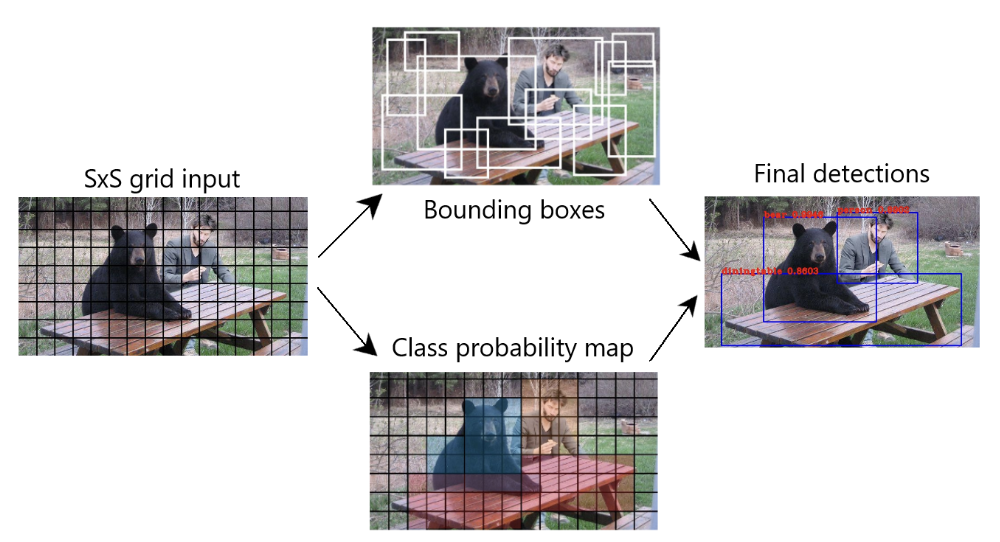

Во-вторых, каждая ячейка отвечает за предсказание вероятностей классов. Это не говорит о том, что какая-то ячейка содержит какой-то объект, только вероятность нахождения объекта. Если ячейка предсказывает автомобиль, это не гарантирует, что автомобиль в действительности присутствует в ней. Это говорит лишь  о том, что если присутствует объект, то этот объект скорее всего автомобиль.

В `YOLO` используются `anchor boxes` (якорные рамки / фиксированные рамки) для прогнозирования `bounding box’ов`. Идея `anchor box’ов` сводится к предварительному определению двух различных форм. И таким образом, мы можем объединить два предсказания с двумя `anchor box’ами` (в целом, мы могли бы использовать даже большее количество `anchor box’ов`). Эти якоря были рассчитаны с помощью датасета `COCO` (Common Objects in Context) и кластеризации k-средних (K-means clustering).

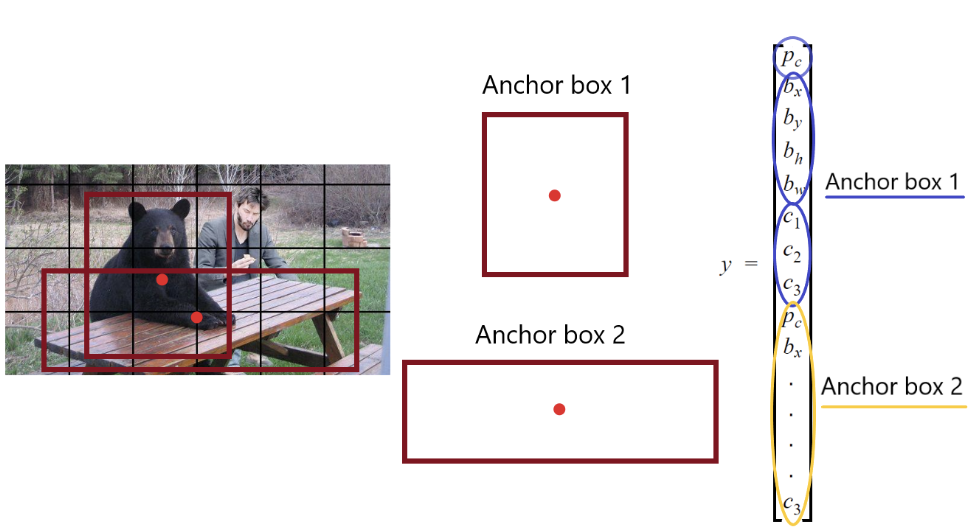

У нас есть сетка, где каждая ячейка предсказывает:

* Для каждого `bounding box'а`:

  * 4 координаты $(t_x , t_y , t_w , t_h)$

  * 1 `objectness error` (ошибка объектности), которая является показателем уверенности в присутствии того или иного объекта

* Некоторое количество вероятностей классов

Если же присутствует некоторое смещение от верхнего левого угла на cx , cy  то прогнозы будут соответствовать:

$$
b_{x} = \sigma(t_{x}) + c_{x}\\ b_{y} = \sigma(t_{y}) + c_{y}\\ b_{w} = p_{w}e^{t_{w}}\\ b_{h} = p_{h}e^{t_{h}}
$$
где $p_{w}$ (ширина) и $p_h$ (высота) соответствуют ширине и высоте `bounding box'а`.  Вместо того, чтобы предугадывать смещение как в `YOLOv2`, авторы прогнозируют координаты местоположения относительно местоположения ячейки.

Этот вывод является выводом нашей нейронной сети. В общей сложности здесь $S x S x [B * (4+1+C)]$ выводов, где $B$ – это количество bounding box'ов, которое может предсказать ячейка на карте объектов, $C$ – это количество классов, 4 – для `bounding box'ов`, 1 – для `objectness prediction` (прогнозирование объектности). За один проход мы можем пройти от входного изображения к выходному тензору, который соответствует обнаруженным объектам на картинке. Также стоит отметить, что `YOLO` прогнозирует `bounding box'ы` в трех разных масштабах.

Теперь, если мы возьмем вероятность и умножим их на доверительные значения, мы получим все `bounding box'ы`, взвешенные по вероятности содержания этого объекта.

Простое нахождение порогового значения избавит нас от прогнозов с низким доверительным значением. Для следующего шага важно определить метрику `IoU` (Intersection over Union / Пересечение над объединением). Эта метрика равняется соотношению площади пересекающихся областей к площади областей объединенных.

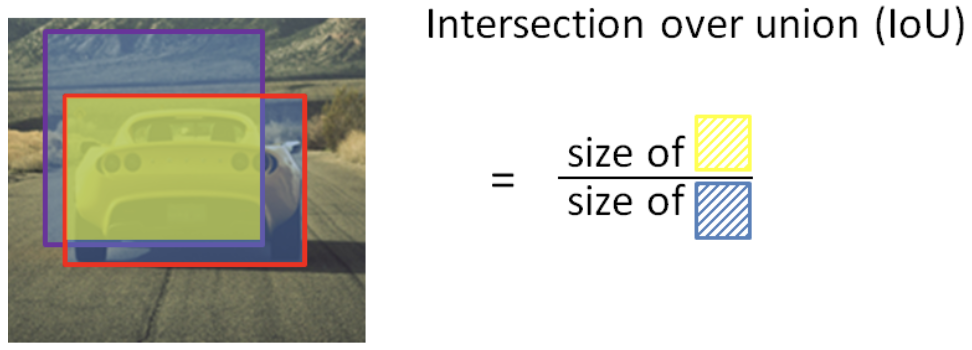

После этого все равно могут остаться дубликаты, и чтобы от них избавиться нужно использовать “подавление не-максимумов” (`non-maximum suppression`). Подавление не-максимумов заключается в следующем: алгоритм берёт `bounding box` с наибольшей вероятностью принадлежности к объекту, затем, среди остальных граничащих `bounding box'ов` с данной областью, возьмёт один с наивысшим `IoU` и подавляет его.

Ввиду того, что все делается за один прогон, эта модель будет работать почти также быстро, как и классификация. К тому же все обнаружения предсказываются одновременно, что означает, что модель неявно учитывает глобальный контекст. Проще говоря, модель может узнать какие объекты обычно встречаться вместе, их относительный размер и расположение объектов и так далее.

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 876.6/876.6 kB 17.0 MB/s eta 0:00:00


## Детекция объектов на фото

Детекция объектов - определение местоположения объектов и их классов на изображении.

Для использования нейросети `YOLO` напишем скрипт:

In [ ]:
from ultralytics import YOLO
from collections import defaultdict
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image, ImageDraw, ImageFont
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Выберем модель (она скачается автоматически при первом запуске скрипта). Кроме минимальной yolov8n.pt, доступны еще несколько:
`yolov8n.pt yolov8s.pt yolov8m.pt yolov8l.pt yolov8x.pt`

Каждая следующая больше, работает медленнее, но и некоторые объекты определяет значительно лучше.

Сравнительные характеристики моделей, а также возможность их запуска на различных устройствах описаны в [статье Степана Жданова](https://habr.com/ru/articles/822917/)

In [ ]:
# Загрузка модели YOLOv8
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 120MB/s]


In [ ]:
# Список цветов для различных классов
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

In [ ]:
# Функция для обработки изображения
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    results = model(image)[0]


    # Получение оригинального изображения и результатов
    new_image = results.orig_img
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)

    # Подготовка словаря для группировки результатов по классам
    grouped_objects = {}

    # Рисование рамок и группировка результатов
    for class_id, box in zip(classes, boxes):
        class_name = classes_names[int(class_id)]
        color = colors[int(class_id) % len(colors)]  # Выбор цвета для класса
        if class_name not in grouped_objects:
            grouped_objects[class_name] = []
        grouped_objects[class_name].append(box)

        # Рисование рамок на изображении
        x1, y1, x2, y2 = box
        cv2.rectangle(new_image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(new_image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Сохранение измененного изображения
    new_image_path = os.path.splitext(image_path)[0] + '_yolo' + os.path.splitext(image_path)[1]
    cv2.imwrite(new_image_path, new_image)

    # Сохранение данных в текстовый файл
    text_file_path = os.path.splitext(image_path)[0] + '_data.txt'
    with open(text_file_path, 'w') as f:
        for class_name, details in grouped_objects.items():
            f.write(f"{class_name}:\n")
            for detail in details:
                f.write(f"Coordinates: ({detail[0]}, {detail[1]}, {detail[2]}, {detail[3]})\n")

    print(f"Processed {image_path}:")
    print(f"Saved bounding-box image to {new_image_path}")
    print(f"Saved data to {text_file_path}")


    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))




В результате работы нейросети получаем объект `boxes`, который содержит информацию о координатах, найденных на изображении объектов, а также принадлежности их к классу (`person`, `cat`, `dog`, `car`, `bus`, `traffic light` и т.д.).

Для дополнительной обработки данные по объектам на изображении сохраняются в текстовый файл

WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.10/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 114.5ms
image 2/2 /usr/local/lib/python3.10/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 253.2ms
Speed: 19.4ms preprocess, 183.9ms inference, 1106.7ms postprocess per image at shape (1, 3, 384, 640)
Processed test.jpg:
Saved bounding-box image to test_yolo.jpg
Saved data to test_data.txt


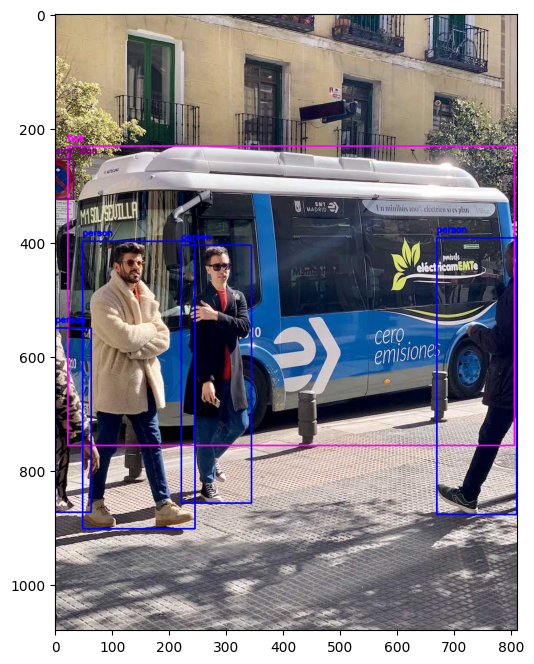

In [ ]:
process_image('test.jpg')

## Детекция объектов в видео-потоке

Видео - это последовательность изображений. Эта часть кода будет работать в `Jupyter Notebook`

Пробуем выполнить детекцию объектов на видео в Colab. Подключаемся к EvaDB

In [ ]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import display, HTML
def pretty_print(df):
    return display(HTML(df.to_html().replace("\n","")))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.7/578.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 899kB/s] 
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 325MB/s]


Загружаем видеозаписи с камер наблюдения. Набор данных состоит из 10 часов видеозаписей, снятых камерой Cannon EOS 550D в 24 различных местах Пекина и Тяньцзиня в Китае.

In [ ]:
# Считываем видео-файлы
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

--2024-10-21 06:53:45--  https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/0e50lkdp3s6hvt1mezt4z/ua_detrac.mp4?rlkey=9r0v57smuxvfq9iun656prwvs&raw=1 [following]
--2024-10-21 06:53:45--  https://www.dropbox.com/scl/fi/0e50lkdp3s6hvt1mezt4z/ua_detrac.mp4?rlkey=9r0v57smuxvfq9iun656prwvs&raw=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdd1cb8509f582f8d8f7bbae2ec.dl.dropboxusercontent.com/cd/0/inline/Cc0fZBmDEv5J4_ucKdqLh0u5firQX6aM1je6lFQHtKWLTuoulDoeNhIUpzhspFBgH7l9fLLb8O0_4keTouaqWtNUpEkkYltsUpXZWuUfQYD85RLvHR1O_dWt-WxpT8bxLss5RJ50V9sC4Ade6IjGmtt6/file# [following]
--2024-10-21 06:53:46--  https://ucdd1cb8509f582f8d8f7bbae2ec.dl.dropboxusercont

Загружаем видео для анализа. Здесь используется регулярное выражение, чтобы загрузить все видео в таблицу с помощью одной команды

In [ ]:
cursor.query("DROP TABLE IF EXISTS ObjectDetectionVideos;").df()
cursor.query("LOAD VIDEO 'ua_detrac.mp4' INTO ObjectDetectionVideos").df()

0
0  Number of loaded VIDEO: 1

Выбираем `YOLO Object Detector` в качестве пользовательской функции (UDF) в EvaDB

In [ ]:
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS Yolo
    TYPE ultralytics
    MODEL 'yolov8m.pt';
""").df()

0
0  Function Yolo already exists, nothing added.

Запускаем `YOLO Object Detector` для видео

In [ ]:
yolo_query = cursor.query("""
    SELECT id, Yolo(data)
    FROM ObjectDetectionVideos
    WHERE id < 20
""")
response = yolo_query.df()
response

id                                             labels  \
0    0  [car, car, car, car, car, car, person, car, ca...   
1    1  [car, car, car, car, car, car, car, car, car, ...   
2    2  [car, car, car, car, car, car, car, person, ca...   
3    3  [car, car, car, car, car, car, car, car, car, ...   
4    4  [car, car, car, car, car, car, car, car, car, ...   
5    5  [car, car, car, car, car, car, person, car, ca...   
6    6  [car, car, car, car, car, car, car, person, ca...   
7    7  [car, car, car, car, car, car, car, car, car, ...   
8    8  [car, car, car, car, car, car, person, car, ca...   
9    9  [car, car, car, car, car, car, car, person, ca...   
10  10  [car, car, car, car, car, car, car, person, ca...   
11  11  [car, car, car, car, car, car, person, car, ca...   
12  12  [car, car, car, car, car, car, car, person, ca...   
13  13  [car, car, car, car, car, car, person, car, ca...   
14  14  [car, car, car, car, car, car, person, car, ca...   
15  15  [car, car, car, car, car, car, person, car, ca...   
16  16  [car, car, car, car, car, car, car, person, ca...   
17  17  [car, car, car, car, car, car, car, person, ca...   
18  18  [car, car, car, car, car, car, car, person, mo...   
19  19  [car, car, car, car, car, person, car, car, ca...   

                                               bboxes  \
0   [[828.603515625, 277.01861572265625, 959.62792...   
1   [[832.1552734375, 278.1465759277344, 959.63830...   
2   [[835.5642700195312, 279.1689147949219, 959.64...   
3   [[839.2291259765625, 279.876953125, 959.635620...   
4   [[843.063232421875, 280.84881591796875, 959.62...   
5   [[847.2269897460938, 282.40478515625, 959.6654...   
6   [[850.6966552734375, 283.1654052734375, 959.43...   
7   [[854.817626953125, 283.7934265136719, 959.555...   
8   [[859.06787109375, 285.23321533203125, 959.824...   
9   [[862.5375366210938, 286.3861083984375, 959.53...   
10  [[631.713623046875, 222.67929077148438, 744.18...   
11  [[871.2513427734375, 288.50506591796875, 959.5...   
12  [[636.3242797851562, 223.41517639160156, 750.0...   
13  [[170.86529541015625, 409.34344482421875, 291....   
14  [[174.27420043945312, 404.84698486328125, 293....   
15  [[887.9122924804688, 292.99810791015625, 959.5...   
16  [[892.8345336914062, 293.4510498046875, 959.53...   
17  [[182.45166015625, 392.1574401855469, 296.3449...   
18  [[901.4002075195312, 295.100341796875, 959.572...   
19  [[647.9462890625, 226.44598388671875, 770.2973...   

                                               scores  
0   [0.91, 0.86, 0.85, 0.83, 0.76, 0.73, 0.72, 0.7...  
1   [0.92, 0.85, 0.84, 0.83, 0.78, 0.76, 0.76, 0.7...  
2   [0.92, 0.84, 0.84, 0.82, 0.81, 0.75, 0.73, 0.7...  
3   [0.91, 0.84, 0.82, 0.8, 0.8, 0.75, 0.74, 0.72,...  
4   [0.9, 0.85, 0.83, 0.8, 0.76, 0.73, 0.72, 0.72,...  
5   [0.89, 0.86, 0.84, 0.8, 0.78, 0.74, 0.72, 0.72...  
6   [0.89, 0.87, 0.85, 0.81, 0.79, 0.73, 0.72, 0.7...  
7   [0.9, 0.87, 0.84, 0.83, 0.83, 0.79, 0.73, 0.67...  
8   [0.89, 0.88, 0.83, 0.82, 0.79, 0.71, 0.68, 0.6...  
9   [0.88, 0.87, 0.84, 0.82, 0.8, 0.75, 0.74, 0.74...  
10  [0.88, 0.88, 0.85, 0.82, 0.8, 0.79, 0.76, 0.71...  
11  [0.9, 0.9, 0.85, 0.8, 0.79, 0.77, 0.69, 0.68, ...  
12  [0.9, 0.88, 0.83, 0.81, 0.78, 0.78, 0.78, 0.67...  
13  [0.9, 0.89, 0.89, 0.83, 0.81, 0.81, 0.72, 0.71...  
14  [0.9, 0.89, 0.88, 0.84, 0.82, 0.81, 0.75, 0.72...  
15  [0.89, 0.88, 0.87, 0.84, 0.82, 0.78, 0.76, 0.7...  
16  [0.88, 0.88, 0.87, 0.82, 0.81, 0.76, 0.75, 0.7...  
17  [0.9, 0.89, 0.87, 0.83, 0.82, 0.78, 0.72, 0.69...  
18  [0.88, 0.88, 0.83, 0.82, 0.8, 0.78, 0.75, 0.7,...  
19  [0.89, 0.87, 0.81, 0.8, 0.78, 0.77, 0.73, 0.72...

Визуализация выходных данных на видео после детекции

In [ ]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read()

    while ret:
        df = detections
        df = df[['bboxes', 'labels']][df.index == frame_id]
        if df.size:
            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[0][0], dfLst[0][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                # object bbox
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness)
                # object label
                cv2.putText(frame, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color1, thickness)
                # frame label
                cv2.putText(frame, 'Frame ID: ' + str(frame_id), (700, 500), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color2, thickness)
            video.write(frame)

            # Stop after twenty frames (id < 20 in previous query)
            if frame_id == 20:
                break

            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()


        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

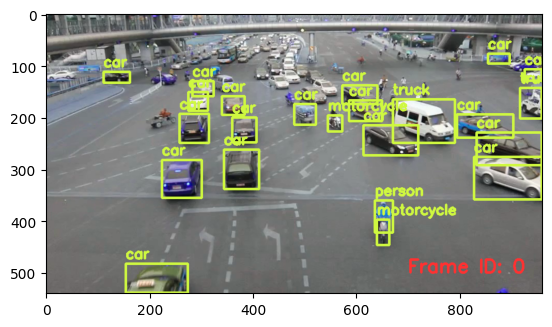

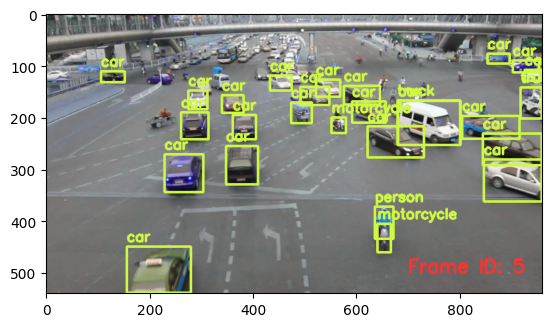

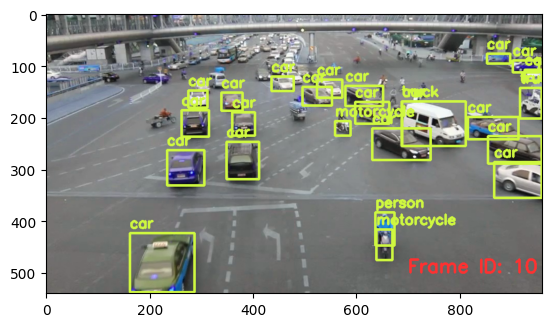

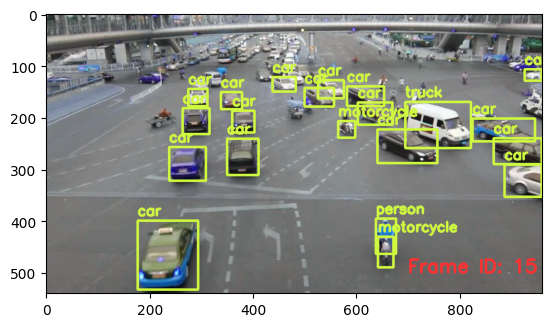

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\t5X...')

In [ ]:
from ipywidgets import Video, Image
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)

При необходимости отключите Yolo

In [ ]:
cursor.query("DROP FUNCTION IF EXISTS Yolo").df()

0
0  Function Yolo successfully dropped

## Сегментация изображения

Сегментация - разделение изображения на классы. Один из самых эффектных способов разобраться с этим процессом будет удаление фона вокруг человека с фото/видео.

Для начала, возьмем фотографию (кадр из предыдущего видео) и применим модель `YoloV8`, предназначенную для сегментации. Как и в случае с детекцией можно выбрать одну из следующих моделей:
  
`yolov8n-seg.pt`, `yolov8s-seg.pt`, `yolov8m-seg.pt`,  `yolov8l-seg.pt` yolov8x-seg.pt

In [ ]:
# Загрузка модели YOLOv8
model = YOLO('yolov8x-seg.pt')

100%|██████████| 137M/137M [00:01<00:00, 120MB/s]


In [ ]:
def process_image(image_path):
    # Проверка наличия папки для сохранения результатов
    if not os.path.exists('results'):
        os.makedirs('results')

    # Загрузка изображения
    image = cv2.imread(image_path)
    image_orig = image.copy()
    h_or, w_or = image.shape[:2]
    image = cv2.resize(image, (640, 640))
    results = model(image)[0]

    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    masks = results.masks.data.cpu().numpy()

    # Наложение масок на изображение
    for i, mask in enumerate(masks):
        color = colors[int(classes[i]) % len(colors)]

        # Изменение размера маски перед созданием цветной маски
        mask_resized = cv2.resize(mask, (w_or, h_or))

        # Создание цветной маски
        color_mask = np.zeros((h_or, w_or, 3), dtype=np.uint8)
        color_mask[mask_resized > 0] = color

        # Сохранение маски каждого класса в отдельный файл
        mask_filename = os.path.join('results', f"{classes_names[classes[i]]}_{i}.png")
        cv2.imwrite(mask_filename, color_mask)

        # Наложение маски на исходное изображение
        image_orig = cv2.addWeighted(image_orig, 1.0, color_mask, 0.5, 0)


    # Сохранение измененного изображения
    new_image_path = os.path.join('results', os.path.splitext(os.path.basename(image_path))[0] + '_segmented' + os.path.splitext(image_path)[1])
    cv2.imwrite(new_image_path, image_orig)
    print(f"Segmented image saved to {new_image_path}")
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB))



В папку `results` сохранятся маски каждого найденного класса, для удобного исследования



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



0: 640x640 1 person, 1 cup, 1 chair, 1 dining table, 1 laptop, 83.9ms
Speed: 2.3ms preprocess, 83.9ms inference, 15.8ms postprocess per image at shape (1, 3, 640, 640)
Segmented image saved to results/woman_segmented.jpg


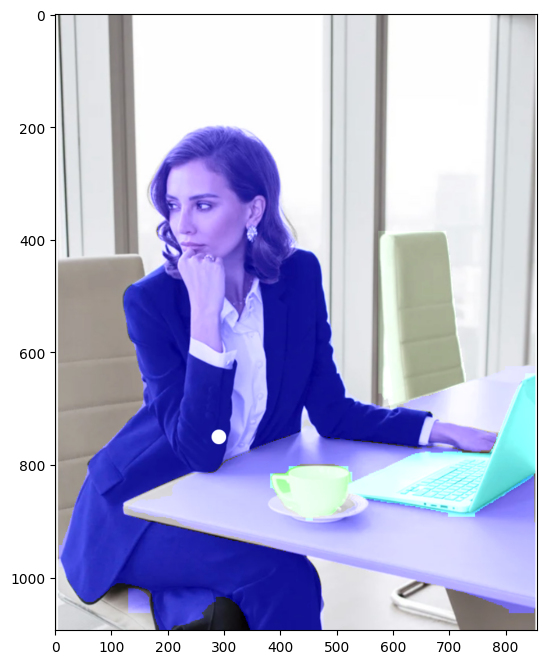

In [ ]:
process_image('/content/drive/MyDrive/машинное зрение/woman.jpg')

Теперь попробуем удалить фон. Для примера будем заменять фон на зеленый. В дальнейшем это поможет в других программах для редактирования фото или видео эффективно размыть края и получить весьма достойный результат!

In [ ]:
# Цвет для выделения объектов класса "person"
person_color = (0, 255, 0)  # Зеленый цвет

In [ ]:
def process_image(image_path):
    frame = cv2.imread(image_path)
    if frame is None:
        print("Ошибка: не удалось загрузить изображение")
        return

    image_orig = frame.copy()
    h_or, w_or = frame.shape[:2]
    image = cv2.resize(frame, (640, 640))
    results = model(image)[0]

    classes = results.boxes.cls.cpu().numpy()
    masks = results.masks.data.cpu().numpy()

    # Создаем зеленый фон
    green_background = np.zeros_like(image_orig)
    green_background[:] = person_color

    # Наложение масок на изображение
    for i, mask in enumerate(masks):
        class_name = results.names[int(classes[i])]
        if class_name == 'person':
            color_mask = np.zeros((640, 640, 3), dtype=np.uint8)
            resized_mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_NEAREST)
            color_mask[resized_mask > 0] = person_color

            color_mask = cv2.resize(color_mask, (w_or, h_or), interpolation=cv2.INTER_NEAREST)

            mask_resized = cv2.resize(mask, (w_or, h_or), interpolation=cv2.INTER_NEAREST)
            green_background[mask_resized > 0] = image_orig[mask_resized > 0]

    # Сохраняем обработанное изображение с добавлением суффикса '_segmented'
    base_name, ext = os.path.splitext(image_path)
    output_path = f"{base_name}_removed_BG{ext}"
    cv2.imwrite(output_path, green_background)
    print(f"Processed image saved to {output_path}")

    # Показываем обработанное изображение
    #cv2.imshow('Processed Image', green_background)
    plt.figure(figsize=(10, 8))
    plt.imshow(green_background)

    cv2.waitKey(0)
    cv2.destroyAllWindows()



0: 640x640 1 person, 1 cup, 1 chair, 1 dining table, 1 laptop, 72.1ms
Speed: 2.3ms preprocess, 72.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Processed image saved to /content/drive/MyDrive/машинное зрение/woman_removed_BG.jpg


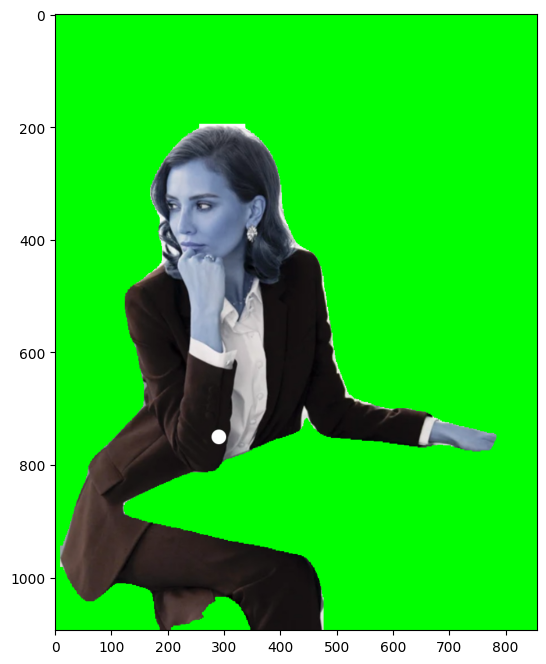

In [ ]:
# Путь к изображению, которое необходимо обработать
image_path = '/content/drive/MyDrive/машинное зрение/woman.jpg'
process_image(image_path)

## Классификация

Процесс обработки изображения, при котором все изображение целиком будет относиться к определенному классу.

Детекция и классификация решают разные задачи и имеют свои особенности и области применения. Вот основные причины, почему не всегда следует использовать детекцию вместо классификации:

1. Сложность задачи:

  **Классификация**: определяет, к какому классу относится весь объект или изображение целиком. Например, классификация фотографии как "собака" или "кошка".

  **Детекция**: находит объекты внутри изображения и определяет их классы и местоположение (например, где на фотографии находится собака и где кошка).

2. Ресурсы и вычислительная мощность:

  **Классификация**: обычно требует меньше вычислительных ресурсов, так как анализируется весь объект или изображение целиком без необходимости определения его частей.

  **Детекция**: более вычислительно затратна, так как требует анализа изображения для поиска объектов и определения их границ.

3. Скорость выполнения:

  **Классификация**: быстрее, так как выполняется одна операция определения класса для всего изображения.

  **Детекция**: медленнее, так как требует многократного анализа изображения для поиска всех объектов и их классификации.

4. Сложность реализации:

  **Классификация**: проще в реализации и настройке, так как обучается на меньших и более структурированных данных.

  **Детекция**: более сложна в реализации, требует больше данных и времени на обучение, особенно если нужно обнаруживать объекты разного размера и формы.

*Когда использовать классификацию*

* Целостное определение класса объекта: если нужно определить класс всего объекта или изображения, а не его частей. Например, определить, что изображено на фотографии (собака или кошка).
* Ограниченные вычислительные ресурсы: в условиях, когда ограничены ресурсы для вычислений и требуется быстрая обработка данных.
* Более точное определение "подклассов". Например, можно находить буквы на изображении с помощью детекции, а затем более точно определять символ при помощи классификации!

*Когда использовать детекцию*

* Множественные объекты на изображении: если на изображении может быть несколько объектов разных классов, и нужно определить их местоположение и классы. Например, обнаружение автомобилей и пешеходов на улице.
* Анализ сложных сцен: когда нужно анализировать сложные сцены, где важно не только определить, какие объекты присутствуют, но и где они находятся.
* Применение в реальном времени: в задачах, где необходимо отслеживать объекты в реальном времени, например, в системах видеонаблюдения.

In [ ]:
model = YOLO('yolov8n-cls.pt')

100%|██████████| 5.31M/5.31M [00:00<00:00, 81.3MB/s]


In [ ]:
def process_image(img):
    # Обработка кадра с помощью модели
    results = model(img)[0]

    # Отображение результатов классификации на изображении
    if results.probs is not None:
        # Доступ к вершинам классификации
        top1_idx = results.probs.top1  # Индекс класса с наивысшей вероятностью
        top1_conf = results.probs.top1conf.item()  # Вероятность для класса с наивысшей вероятностью
        class_name = results.names[top1_idx]  # Получаем имя класса по индексу

        # Отображаем класс и вероятность на кадре
        label = f"{class_name}: {top1_conf:.2f}"
        cv2.putText(img, label, (100, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 0, 0), 2)

    # Показываем обработанное изображение

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return image


0: 224x224 tiger_cat 0.75, Egyptian_cat 0.10, tabby 0.10, lynx 0.03, fox_squirrel 0.00, 4.1ms
Speed: 47.1ms preprocess, 4.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


True

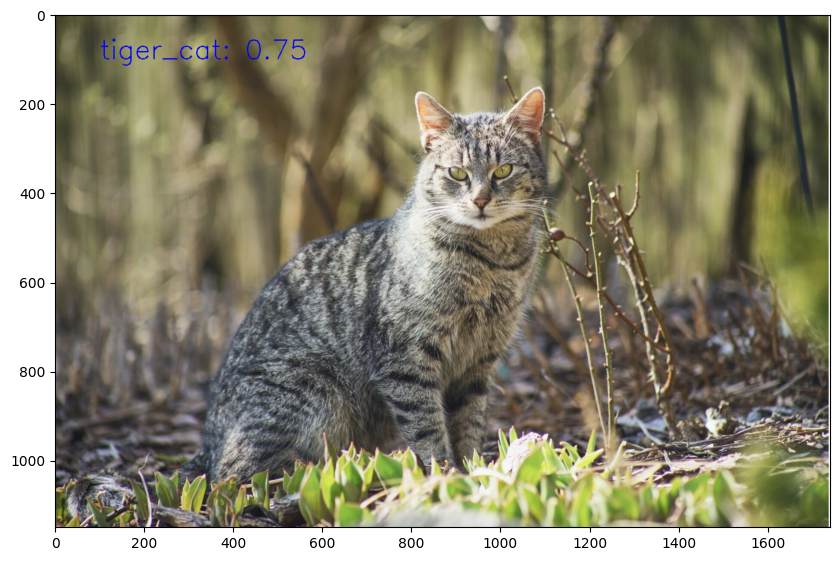

In [ ]:
image = cv2.imread('/content/drive/MyDrive/машинное зрение/cat.jpg')
image = process_image(image)
cv2.imwrite('result.jpg', image)

## Поиск ключевых точек тела - определения позы человека

Некоторые из способов применения данной модели:

* Тренировки спортсменов: помощь в анализе движений спортсменов для улучшения их техники
* Реабилитация: мониторинг и корректировка движений пациентов во время реабилитационных упражнений.
* Обнаружение падений: автоматическое обнаружение падений и других опасных ситуаций для пожилых людей или работников на производстве.
* Анимация: создание реалистичных движений для анимационных персонажей в фильмах и видеоиграх.
* Виртуальная и дополненная реальность: реалистичное отслеживание движений пользователей для создания интерактивных VR и AR приложений.
* Анализ поведения клиентов: изучение движения и поведения клиентов в магазинах для оптимизации выкладки товаров и улучшения обслуживания.
* Цифровые зеркала: виртуальная примерка одежды, позволяющая клиентам видеть, как они будут выглядеть в разных нарядах без необходимости физической примерки.

In [ ]:
# Загрузка модели YOLOv8-Pose
model = YOLO('yolov8n-pose.pt')

100%|██████████| 6.52M/6.52M [00:00<00:00, 108MB/s]


In [ ]:
# Словарь цветов для различных классов
colors = {
    'white': (255, 255, 255),
    'red': (0, 0, 255),
    'blue': (255, 0, 0)
}

In [ ]:
def draw_skeleton(image, keypoints, confs, pairs, color):
    for (start, end) in pairs:
        if confs[start] > 0.5 and confs[end] > 0.5:
            x1, y1 = int(keypoints[start][0]), int(keypoints[start][1])
            x2, y2 = int(keypoints[end][0]), int(keypoints[end][1])
            if (x1, y1) != (0, 0) and (x2, y2) != (0, 0):  # Игнорирование точек в (0, 0)
                cv2.line(image, (x1, y1), (x2, y2), color, 2)


In [ ]:
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    if image is None:
        print("Ошибка: не удалось загрузить изображение")
        return

    # Обработка изображения с помощью модели
    results = model(image)[0]

    # Проверка на наличие обнаруженных объектов
    if hasattr(results, 'boxes') and hasattr(results.boxes, 'cls') and len(results.boxes.cls) > 0:
        classes_names = results.names
        classes = results.boxes.cls.cpu().numpy()
        boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)

        # Обработка ключевых точек
        if results.keypoints:
            keypoints = results.keypoints.data.cpu().numpy()
            confs = results.keypoints.conf.cpu().numpy()

            for i, (class_id, box, kp, conf) in enumerate(zip(classes, boxes, keypoints, confs)):
                draw_box=False
                if draw_box:
                    class_name = classes_names[int(class_id)]
                    color = colors['white']
                    x1, y1, x2, y2 = box
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                # Визуализация ключевых точек с номерами
                for j, (point, point_conf) in enumerate(zip(kp, conf)):
                    if point_conf > 0.5:  # Фильтрация по уверенности
                        x, y = int(point[0]), int(point[1])
                        if (x, y) != (0, 0):  # Игнорирование точек в (0, 0)
                            cv2.circle(image, (x, y), 5, colors['blue'], -1)
                            cv2.putText(image, str(j), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors['blue'], 2)

                # Рисование скелета
                draw_skeleton(image, kp, conf, [(5, 7), (7, 9), (6, 8), (8, 10)], colors['white']) # Руки
                draw_skeleton(image, kp, conf, [(11, 13), (13, 15), (12, 14), (14, 16)], colors['red']) # Ноги
                draw_skeleton(image, kp, conf, [(5, 11), (6, 12)], colors['blue']) # Тело

    # Сохранение и отображение результатов
    output_path = os.path.splitext(image_path)[0] + "_pose_detected.jpg"
    cv2.imwrite(output_path, image)
    print(f"Сохранено изображение с результатами: {output_path}")

    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Показываем обработанное изображение

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))



0: 640x448 1 person, 60.9ms
Speed: 3.4ms preprocess, 60.9ms inference, 40.1ms postprocess per image at shape (1, 3, 640, 448)
Сохранено изображение с результатами: /content/drive/MyDrive/машинное зрение/man_pose_detected.jpg


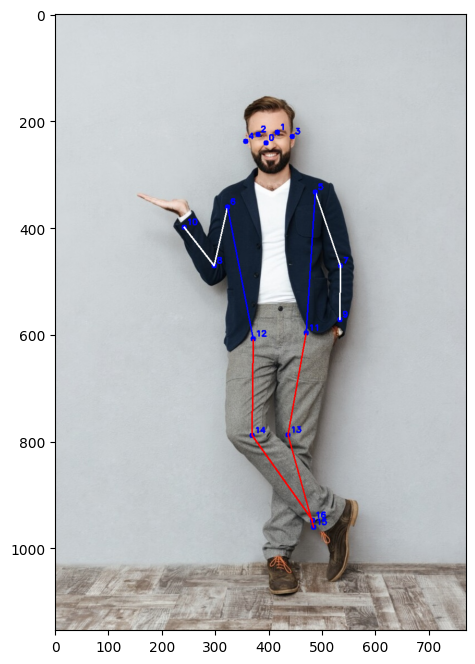

In [ ]:
# Путь к изображению для обработки
image_path = '/content/drive/MyDrive/машинное зрение/man.jpg'
process_image(image_path)

## Задание для самостоятельного выполнения. Обнаружение переломов костей

Каждое изображение в наборе данных помечено либо ограничивающими рамками, либо масками сегментации на уровне пикселей для указания местоположения и степени обнаруженного перелома. Это облегчает обучение и оценку алгоритмов обнаружения переломов костей.

Набор данных для обнаружения переломов костей является полезным ресурсом для исследователей и разработчиков, которые хотят обучить модели машинного обучения, уделяя особое внимание алгоритмам обнаружения объектов, автоматически обнаруживать и классифицировать переломы костей на рентгеновских изображениях. Разнообразие классов переломов в наборе данных позволяет разрабатывать надежные модели, способные точно идентифицировать переломы в различных областях верхних конечностей.

Цель создания этого набора данных — ускорить разработку решений на основе компьютерного зрения для автоматического обнаружения переломов, способствуя прогрессу в медицинской диагностике и улучшая уход за пациентами.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.applications import DenseNet121
#import albumentations as A
#from albumentations.pytorch import ToTensorV2
from keras import backend as keras
from ultralytics import YOLO
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

zip_file = '/content/drive/MyDrive/машинное зрение/BoneFractureYolo8.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

Mounted at /content/drive/
['.config', 'test', 'README.dataset.txt', 'yolov8n-pose.pt', 'yolov8x-seg.pt', 'ua_detrac.mp4', 'result.jpg', 'valid', 'evadb_data', 'b673f975713f22730c2ed3e24fbaef6d', 'test_yolo.jpg', 'test_data.txt', 'data.yaml', 'video.mp4', 'yolov8n.pt', 'train', 'yolov8n-cls.pt', 'results', 'drive', 'yolov8m.pt', 'sample_data']


In [ ]:
train_images = 'train/images'
train_labels = 'train/labels'

test_images = 'test/images'
test_labels = 'test/labels'

val_images = 'valid/images'
val_labels = 'valid/labels'

In [ ]:
print('Number of train frames: ' + str(len(os.listdir(train_images))))
print('Number of train labels: ' + str(len(os.listdir(train_labels))))
print('Number of val frames: ' + str(len(os.listdir(val_images))))
print('Number of val labels: ' + str(len(os.listdir(val_labels))))
print('Number of test frames: ' + str(len(os.listdir(test_images))))
print('Number of test labels: ' + str(len(os.listdir(test_labels))))
print('Total frames: ' + str(len(os.listdir(train_images)) + len(os.listdir(test_images)) + len(os.listdir(val_images))))

Number of train frames: 3631
Number of train labels: 3631
Number of val frames: 348
Number of val labels: 348
Number of test frames: 169
Number of test labels: 169
Total frames: 4148


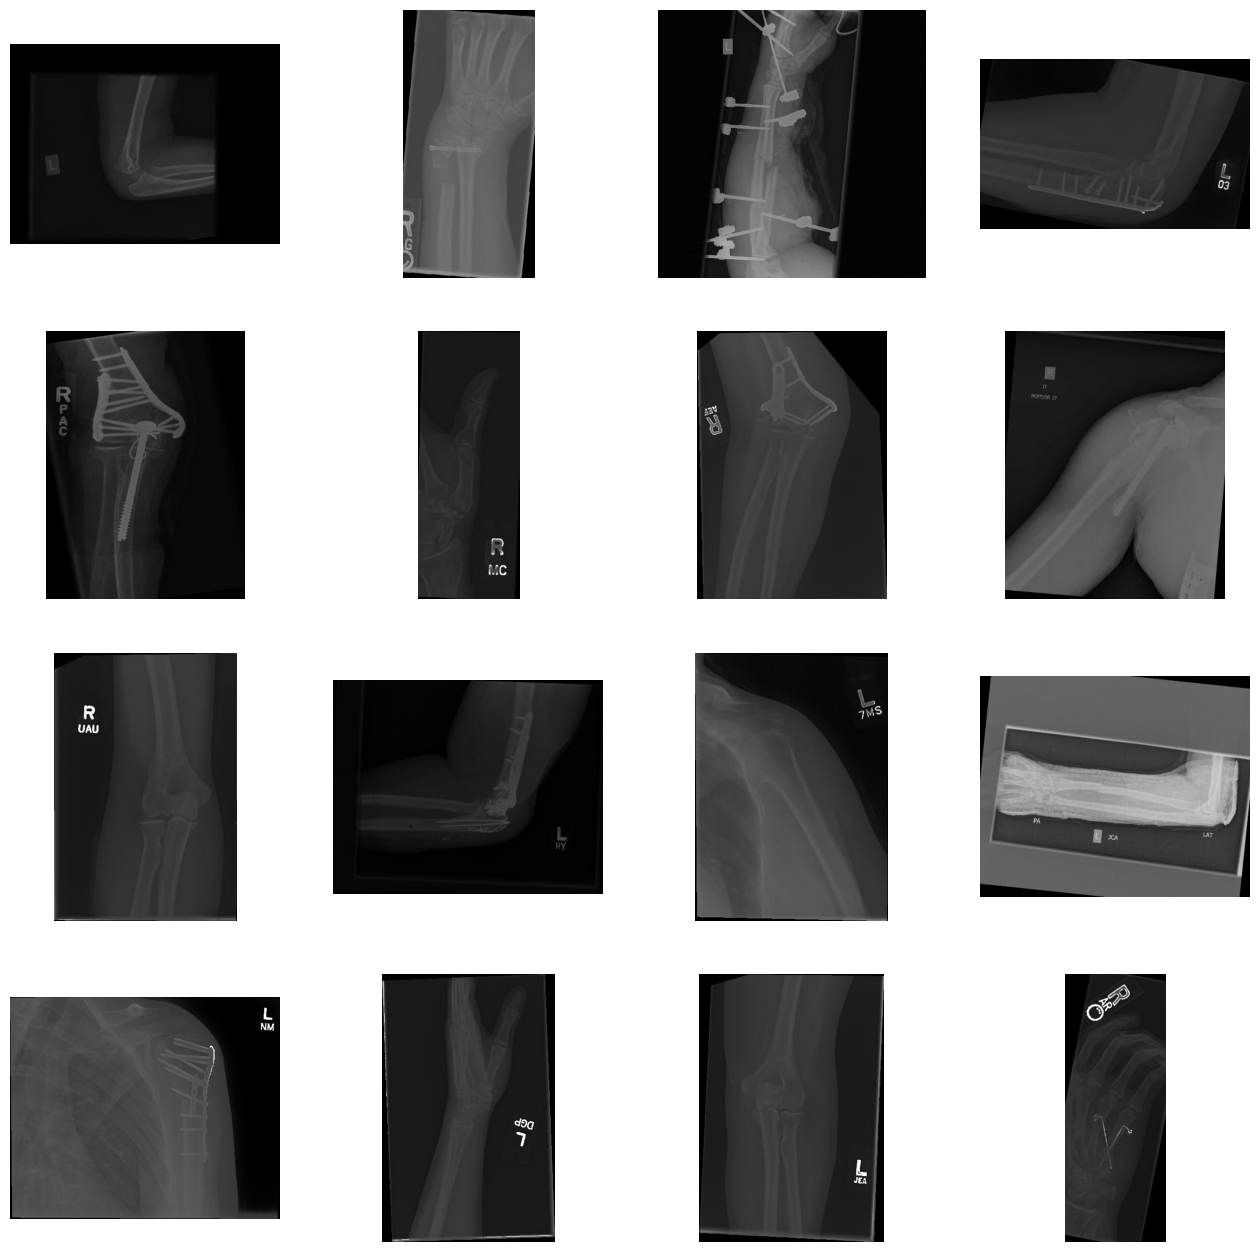

In [ ]:
# Получим список всех файлов изображений в каталоге обучающих изображений
image_files = os.listdir(train_images)

# Выберем 16 случайных файлов изображений из списка
random_images = random.sample(image_files, 16)

# Параметры вывода изображений
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Выберем случайные изображения и строим график обнаружения объектов
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4

    # Загружаем изображени
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Загружаем подписи к этим изображениям
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")


    # Проходим по меткам и строим график обнаружения объектов
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Визуализируем изображения с обнаруженными объектами
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [ ]:
# Загружаем модель YOLOv8
model = YOLO('yolov8s.pt')

# Обучаем модель
model.train(data = 'data.yaml',
    epochs=60,
    seed=12345,
    batch=16,
    imgsz=640,  # Размер изображения
    augment=True,  # Подключаем аугментацию
    flipud=0.5,    # Переворачиваем изображения вверх ногами
    fliplr=0.5,    # Переворачивайте изображения влево-вправо
    scale=0.5,     # Шкалирование
    shear=0.2,     # Сдвиг
    mosaic=1.0,    # Мозаичная аугментаия (установите значение 0.0, чтобы отключить)
    mixup=0.0      # Перемешивание (установите значение 0.0, чтобы отключить)
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 46.2MB/s]


Ultralytics 8.3.18 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=12345, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 27.2MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# Оценим метрики после обучения и валидации
results = model.val(data='data.yaml')

# Показатели оценки доступа
map50_95 = results.box.map
map50 = results.box.map50
map75 = results.box.map75

# Построим столбиковую диаграмму
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[map50_95, map50, map75])

# Заголовок и подписи осей
ax.set_title('Показатели оценки YOLOv8')
ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')

# Размер графика
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Добавим значения над столбцами
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()


In [ ]:
# Загружаем имена классов (замените их фактическими названиями классов, которые у вас есть).
# Предполагается, что имена классов перечислены в том же порядке, в каком они указаны в файлах меток
class_names = ['Elbow Positive', 'Fingers Positive', 'Forearm Fracture', 'Humerus Fracture', 'Shoulder Fracture', 'Wrist Positive']

# Путь к каталогу тестовых изображений
test_images_path = test_images

# Получим список всех тестовых файлов изображений
test_image_files = os.listdir(test_images_path)

# Выберем случайно 16 тестовых изображений для отображения
random_test_images = random.sample(test_image_files, 16)

# Параметры графиков
fig, axs = plt.subplots(4, 4, figsize=(20, 10))

# Перебираем случайные изображения и отображаем их с предсказаниями
for i, image_file in enumerate(random_test_images):
    # Загружаем изображение
    image_path = os.path.join(test_images_path, image_file)
    image = cv2.imread(image_path)

    # Делаем прогноз модели на изображении
    results = model.predict(source=image_path, show=False)  # Установите show=True при локальном запуске, чтобы увидеть всплывающие окна

    # Рисуем ограничивающие рамки на изображении
    # В `results` лежат объекты, содержащие прогнозы, используем его для рисования ограничивающих рамок
    for result in results:
        # Повторяйте для каждого прогноза
        for box in result.boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Координаты ограничивающего прямоугольника
            class_id = int(box.cls[0])  # Извлеките идентификатор класса
            confidence = box.conf[0]  # Извлекаем оценку достоверности

            # Получаем названия классов
            class_name = class_names[class_id]

            # Рисуем рамку
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color, thickness=2

            # рисуем название класса и уверенность в себе на изображении
            label = f"{class_name} {confidence:.2f}"
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            label_ymin = max(y_min, label_size[1] + 10)
            cv2.rectangle(image, (x_min, label_ymin - label_size[1] - 10), (x_min + label_size[0], label_ymin + 5), (0, 255, 0), -1)
            cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Изобрадение с прогнозом
    row = i // 4
    col = i % 4
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')
plt.show()


### Улучшение построенной модели

In [ ]:
def objective(trial):
    # Определяем гиперпараметры для подбора
    lr0 = trial.suggest_float('lr0', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=8)
    imgsz = trial.suggest_int('imgsz', 320, 640, step=32)
    epochs = trial.suggest_int('epochs', 10, 100, step=10)

    # Параметры аугментации
    augment = trial.suggest_categorical('augment', [True, False])  # Use built-in augmentations

    # Загружаем модель
    model = YOLO('yolov8s.pt')

    # Обучаем с подбором гиперпараметров
    results = model.train(
        data='data.yaml',  #
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        lr0=lr0,
        augment=augment,
        project='YOLOv8_Optuna',  # Сохраняем результаты в папке проекта
        name='optuna_trial',
        verbose=False
    )

In [ ]:
# Запускаем Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Отрегулируйте количество запусков по мере необходимости

# Получим оптимальные значения гиперпараметров
best_params = study.best_params
print('Best hyperparameters:', best_params)

In [ ]:
# Оценка модели на валидации
metrics = model.val()
map50 = metrics['metrics/mAP_0.5']
map50

In [ ]:
# Обучаем модель с оптимальными гиперпараметрами
best_model = YOLO('yolov8s.pt')
best_model.train(
    data='data.yaml',
    epochs=best_params['epochs'],
    imgsz=best_params['imgsz'],
    batch=best_params['batch_size'],
    lr=best_params['lr'],
    seed=42,
    augment=True,
    augment_kwargs={
        'flip_lr': best_params['flip_lr'],
        'rotate': best_params['rotate'],
        'scale': best_params['scale'],
    }
)

In [ ]:
# Визуализация тестовых изображений с прогнозами
# Загружаем тестовые изображения
test_image_files = os.listdir(test_images)

# Выбираем произвольные 8 изображений
random_test_images = random.sample(test_image_files, 8)

# Параметры графика
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Перебираем случайные изображения и отображаем их с предсказаниями
for i, image_file in enumerate(random_test_images):
    image_path = os.path.join(test_images, image_file)
    image = cv2.imread(image_path)

    # Строим прогноз
    results = best_model.predict(source=image_path, show=False)

    # Рисуем рамку изображения
    for result in results:
        # Повторяем для каждого предсказания
        for box in result.boxes:
            x_min, y_min, x_max, y_max = map(int, box.xyxy[0])  # Координаты рамки
            class_id = int(box.cls[0])  # Извлекаем идентификатор класса
            confidence = box.conf[0]  # Извлекаем оценку достоверности

            # Получим название класса
            class_name = class_names[class_id]

            # Рисуем рамку
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green color, thickness=2

            # Рисуем название класса и уверенность на изображении
            label = f"{class_name} {confidence:.2f}"
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            label_ymin = max(y_min, label_size[1] + 10)
            cv2.rectangle(image, (x_min, label_ymin - label_size[1] - 10), (x_min + label_size[0], label_ymin + 5), (0, 255, 0), -1)
            cv2.putText(image, label, (x_min, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

    # Построим изображение с предсказаниями
    row = i // 4
    col = i % 4
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')
plt.show()



In [ ]:
# Построение графиков показателей оценки
%matplotlib inline
metrics = best_model.val()  # Получим показатели финальной модели
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Заголовок и подписи осей
ax.set_title('Показатели оценки YOLO')
ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')


fig = plt.gcf()
fig.set_size_inches(8, 6)

# Добавляем значения поверх столбцов
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

plt.show()

Дополнительно можно ознакомиться с [примером реализации на Tensorflow](https://www.kaggle.com/code/anastasiakim/yolov3-tensorflow)